In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re #for regular expressions
import matplotlib.ticker as mtick
from urllib.parse import urlparse
import nltk

In [2]:
datos=pd.read_csv('train.csv')

In [3]:
datos.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
totalDatos = datos.shape[0]

# Veracidad de los tweets

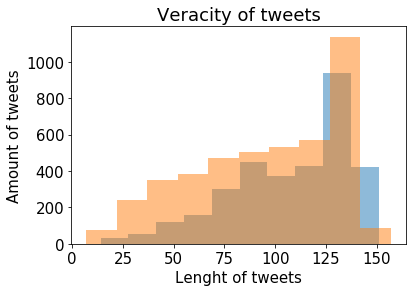

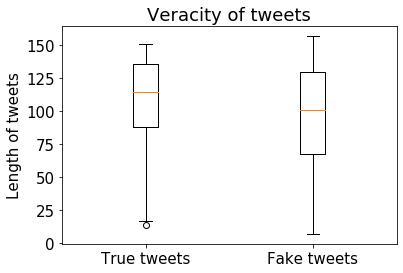

In [5]:
tweets = datos
tweets["size"] = tweets["text"].map(len)

true_tweets = tweets[tweets["target"] == 1]
fake_tweets = tweets[tweets["target"] == 0]

plt.rcParams.update({'font.size': 15})

#histogram
plt.hist(true_tweets["size"], 10, alpha=0.5, label='True tweets')
plt.hist(fake_tweets["size"], 10, alpha=0.5, label='Fake tweets')

plt.title("Veracity of tweets")
plt.xlabel("Lenght of tweets")
plt.ylabel("Amount of tweets")

#Boxplots
data_boxes = {'True tweets': true_tweets["size"], 'Fake tweets': fake_tweets["size"]}

fig, ax = plt.subplots()
bp = ax.boxplot(data_boxes.values())
ax.set_xticklabels(data_boxes.keys())
ax.set_title('Veracity of tweets')
ax.set_ylabel('Length of tweets')
plt.show()

# Análisis de los valores nulos por columna

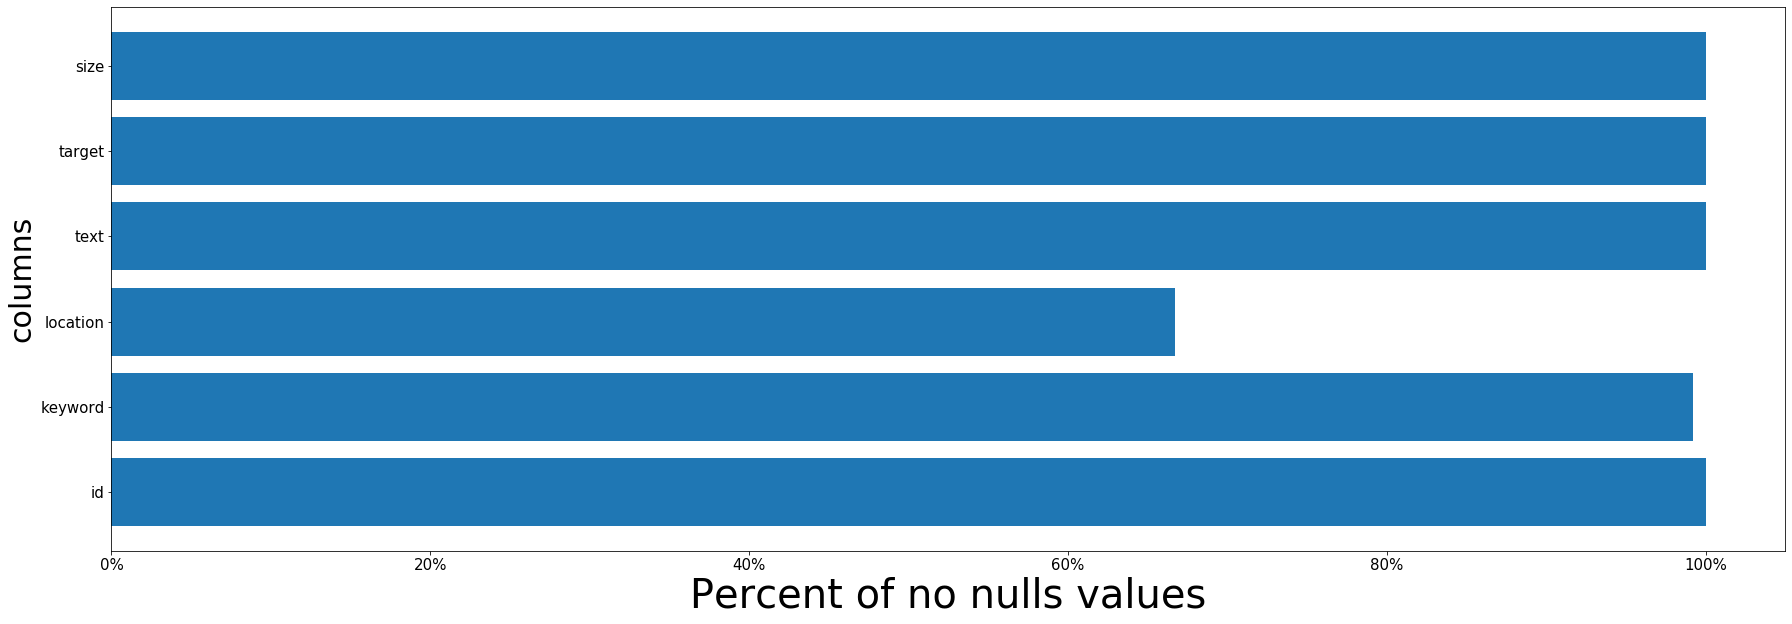

In [6]:
#Determinar el porcentaje de datos no nulos en cada columna para saber cuales tener en cuenta
nan_columns = []
nan_values = []

for column in datos.columns:
    nan_columns.append(column)
    nan_values.append(100*datos[column].notnull().sum()/datos.shape[0])

fig, ax = plt.subplots(figsize=(30,10))

plt.rcParams.update({'font.size': 60})

#format x axis in percentage
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)

plt.xlabel("Percent of no nulls values", fontsize=40)
ax.set_ylabel('columns', fontsize=30)

plt.barh(nan_columns, nan_values);

# Qué porcentaje de tweets tienen links?

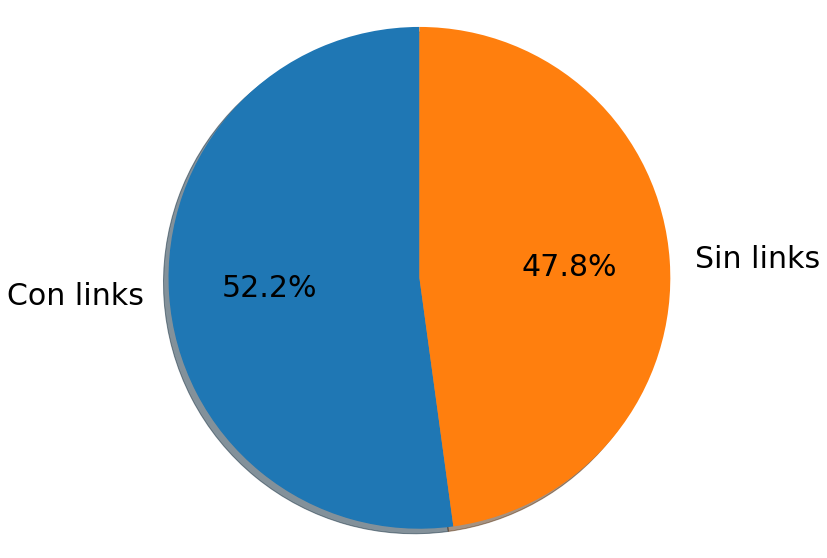

In [7]:
#Determina si una cadena contiene uno o mas links o no
def hasLinks(string): 
    links = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", string) 
    return len(links) > 0

#Se determina la cantidad de tweets que tienen links
datos["has_links"] = datos.apply(lambda row: hasLinks(row['text']), axis=1) 

porcentajeConLinks = 100*datos["has_links"].sum()/totalDatos
porcentajeSinLinks = 100 - porcentajeConLinks

labels = "Con links", "Sin links"
sizes = [porcentajeConLinks, porcentajeSinLinks]

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops ={"size":30} )
ax1.axis('equal');

# Análisis de los sitios más linkeados

In [8]:
def getDomain(url):
    parsed_uri = urlparse(url)
    result = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return result;
    
def getlinks(string): 
    URL_REGEX = r"""((?:(?:https|ftp|http)?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|org|uk)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|uk|ac)\b/?(?!@)))"""
    links = re.findall(URL_REGEX, string)
    
    if(len(links) > 0):
        return list(map(getDomain, links))
    
    return ();

#Agregamos unicamente los links a los tweets que ya vimos que tienen links
datos["links"] = datos.apply(lambda row: getlinks(row['text']), axis=1)
datos = datos.explode("links")
#print(datos.links.unique().tolist())
print("Cantidad de sitios linkeados (sin duplicados): " + str(datos.links.nunique() -1))
#Pendiente: extraer el dominio del sitio
print("=> No se pueden analizar los sitios mas linkeados porque casi todos están acortados con t.co")

Cantidad de sitios linkeados (sin duplicados): 6
=> No se pueden analizar los sitios mas linkeados porque casi todos están acortados con t.co


# Palabras mas utilizadas en los tweets verdaderos

In [9]:
def sacar_puntuacion(x):
  puntuacion="@#!?,¿+&*_[]-%.:/();$=><|{}^" + "'`"
  for p in puntuacion:
    x=x.replace(p, f'')
  return x 

def limpiar_texto(x):
    x = re.sub(r"&amp", "and", x)
    x=x.lower()

    x=sacar_puntuacion(x)
    return x

In [10]:
true_tweets = tweets[tweets["target"] == 1]
#print(true_tweets.count())

clean_true_tweets=true_tweets['text'].apply(limpiar_texto)
textototal = clean_true_tweets.values

textototal = " ".join(textototal)
frecuencia_palabras = nltk.FreqDist(textototal.split(" "))
datos_frecuencia_palabras=frecuencia_palabras.most_common(30)

palabras=[]
cantidad=[]
for clave,valor in datos_frecuencia_palabras:
  palabras.append(clave)
  cantidad.append(valor)

In [11]:
palabras_con_cantidad=pd.DataFrame({"palabras":palabras,"cantidad":cantidad})

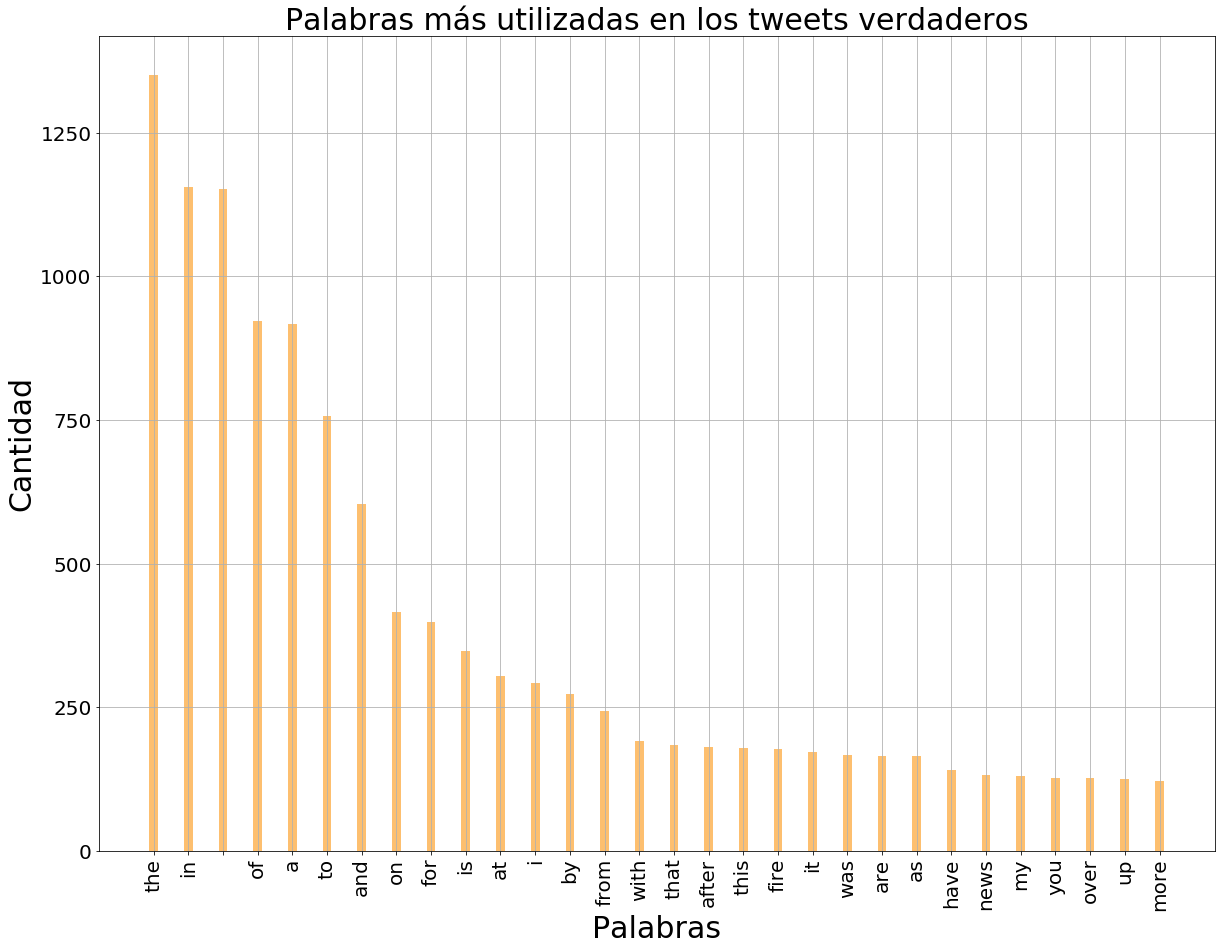

In [12]:
plt.figure(figsize=[20,15])
x=np.arange(len(palabras_con_cantidad['palabras']))
plt.bar(x,palabras_con_cantidad['cantidad'], width = 0.25,color=plt.cm.Paired(6))
plt.grid(True)
plt.xticks(np.arange(len(palabras_con_cantidad['cantidad'])),palabras_con_cantidad['palabras'],rotation='vertical',size=20) 
plt.yticks(size=20)
plt.title('Palabras más utilizadas en los tweets verdaderos',size=30)
plt.xlabel('Palabras',size=30)
plt.ylabel('Cantidad',size=30)
plt.show()

# Palabras más utilizadas en tweets falsos

In [13]:
fake_tweets = tweets[tweets["target"] == 0]
#print(fake_tweets.count())

clean_fake_tweets=fake_tweets['text'].apply(limpiar_texto)
textototal = clean_fake_tweets.values
textototal = " ".join(textototal)
frecuencia_palabras = nltk.FreqDist(textototal.split(" "))
datos_frecuencia_palabras=frecuencia_palabras.most_common(30)

palabras=[]
cantidad=[]
for clave,valor in datos_frecuencia_palabras:
  palabras.append(clave)
  cantidad.append(valor)

In [14]:
palabras_con_cantidad=pd.DataFrame({"palabras":palabras,"cantidad":cantidad})

In [ ]:
plt.figure(figsize=[20,15])
x=np.arange(len(palabras_con_cantidad['palabras']))
plt.bar(x,palabras_con_cantidad['cantidad'], width = 0.25,color=plt.cm.Paired(6))
plt.grid(True)
plt.xticks(np.arange(len(palabras_con_cantidad['cantidad'])),palabras_con_cantidad['palabras'],rotation='vertical',size=20) 
plt.yticks(size=20)
plt.title('Palabras más utilizadas en los tweets falsos',size=30)
plt.xlabel('Palabras',size=30)
plt.ylabel('Cantidad',size=30)
plt.show()